In [1]:
import cv2
import torch
from metrics_and_losses import metrics
import utils.utils as utils
import numpy as np
import matplotlib.pyplot as plt
from palette_classification import color_processing, palette
from utils import utils, segmentation_labels
import glob
from typing import OrderedDict

/Users/francescobaraldi/venvs/cv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Assigns a specific color to each relevant region of a segmented image.
labels = OrderedDict({ label: segmentation_labels.labels[label] for label in ['skin', 'hair', 'lips', 'eyes'] })

skin_idx = utils.from_key_to_index(labels, 'skin')
hair_idx = utils.from_key_to_index(labels, 'hair')
lips_idx = utils.from_key_to_index(labels, 'lips')
eyes_idx = utils.from_key_to_index(labels, 'eyes')

In [3]:
palettes_dir = 'palette_classification/palettes/'
example_images_dir = 'palette_classification/example_images/'

# loading palettes
palette_filenames = glob.glob(palettes_dir + '*.csv')
reference_palettes = [palette.PaletteRGB().load(
    palette_filename.replace('\\', '/'), header=True) for palette_filename in palette_filenames]

# loading example image
img = cv2.cvtColor(cv2.imread(example_images_dir + 'fig1.png'), cv2.COLOR_BGR2RGB)
img_segmented = cv2.cvtColor(cv2.imread(example_images_dir + 'figseg1.png'), cv2.COLOR_BGR2RGB)

autumn


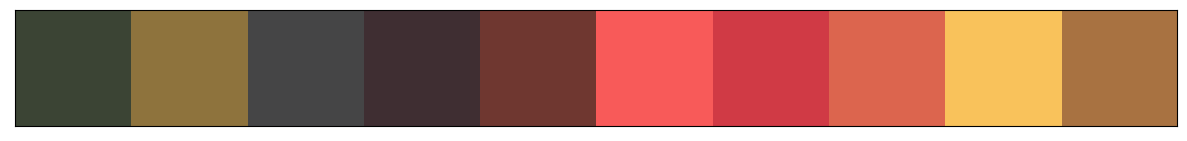

spring


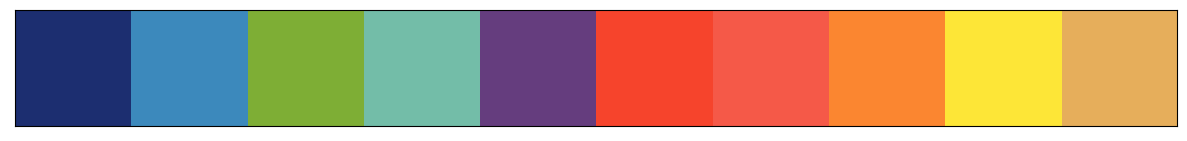

winter


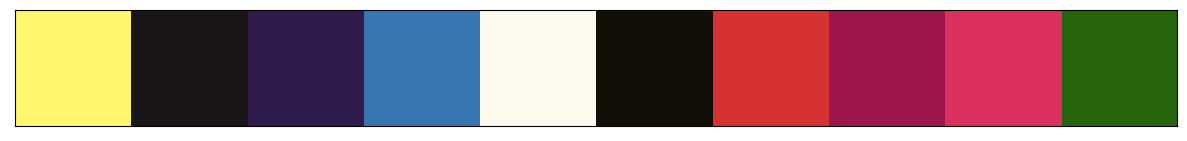

summer


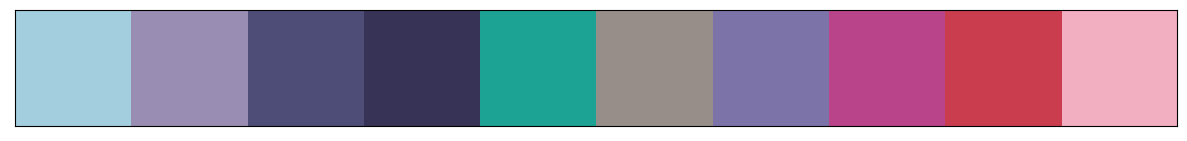

In [4]:
for reference_palette in reference_palettes:
  print(reference_palette.description())
  reference_palette.plot(tile_size=15)

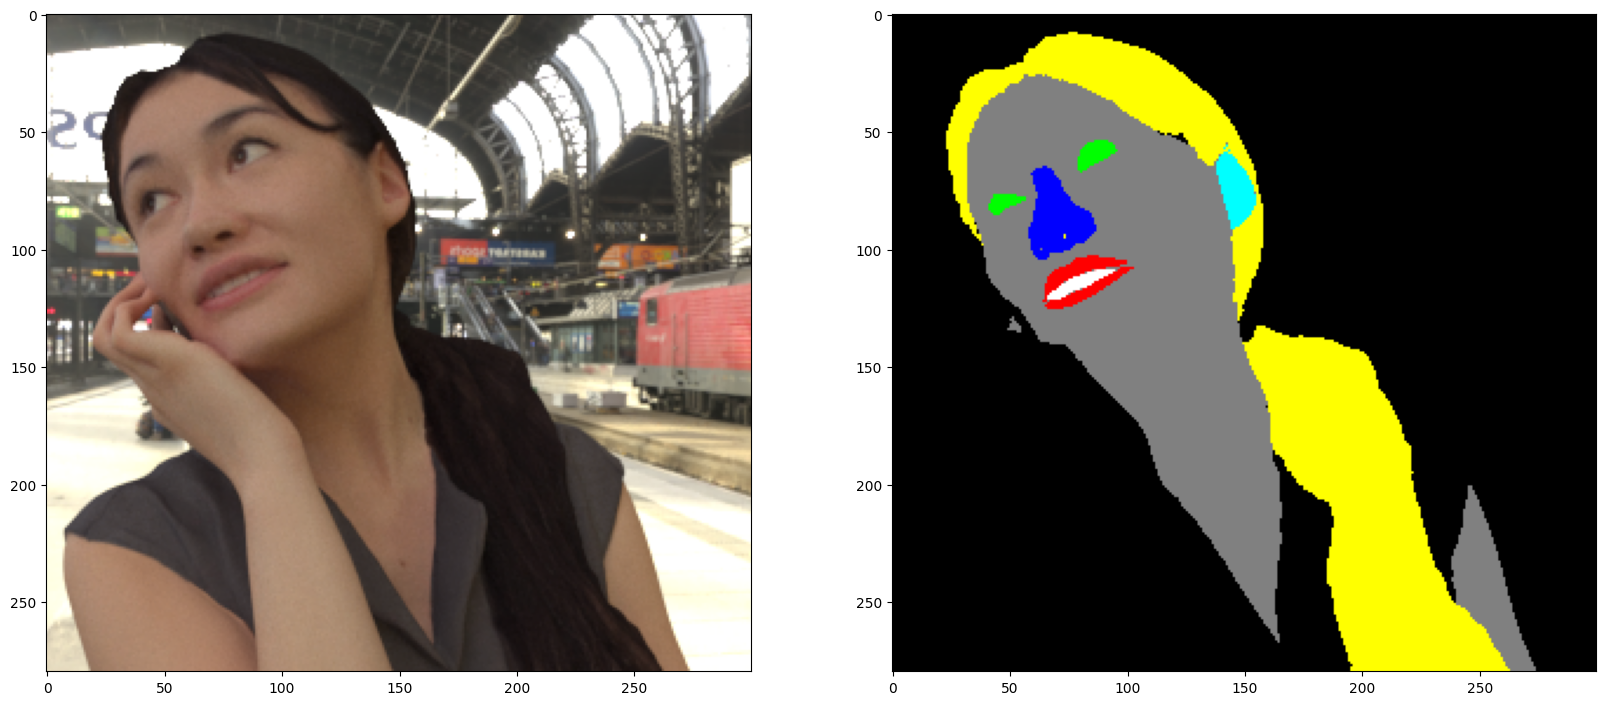

In [5]:
# plotting example image
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_segmented)
plt.show()

In [6]:
# converting example image to standard format
img = utils.from_HWD_to_DHW(torch.from_numpy(img))
img_segmented = utils.from_HWD_to_DHW(torch.from_numpy(img_segmented))

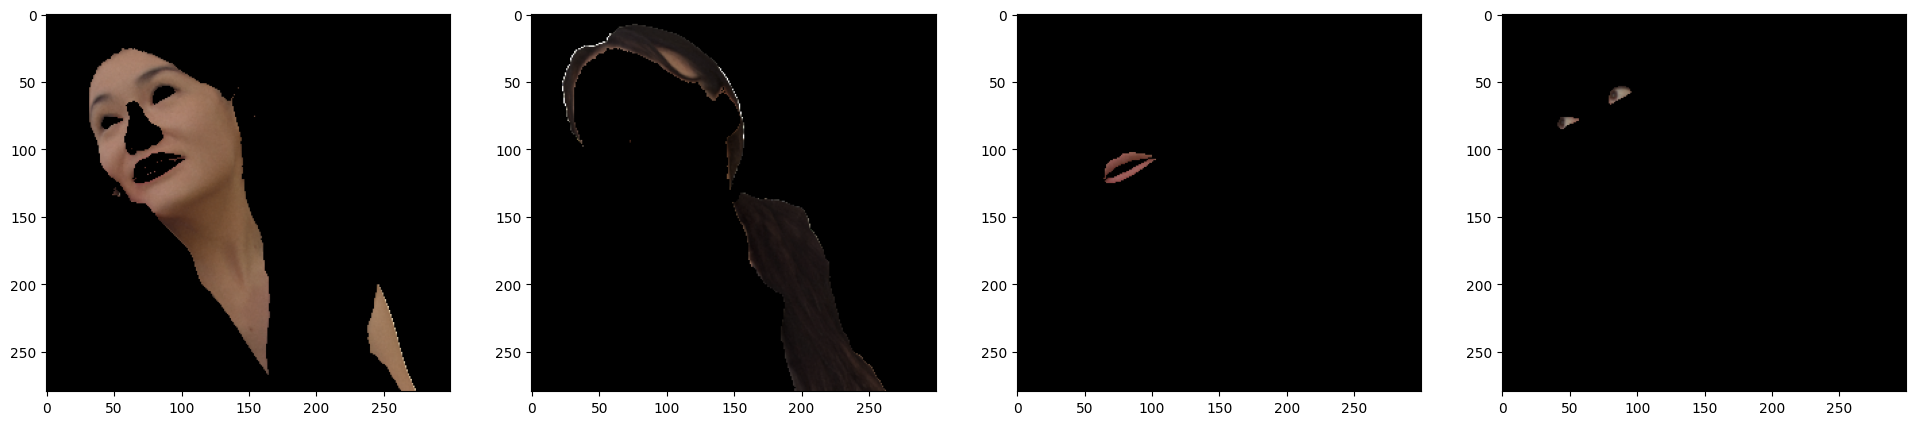

In [7]:
# computing and plotting segmentation masks for labels
segmentation_masks = color_processing.compute_segmentation_masks(img_segmented, labels)
img_masked = color_processing.apply_masks(img, segmentation_masks)
plt.figure(figsize=(24, 14))
plt.subplot(1, 4, 1)
plt.imshow(utils.from_DHW_to_HWD(img_masked[0]))
plt.subplot(1, 4, 2)
plt.imshow(utils.from_DHW_to_HWD(img_masked[1]))
plt.subplot(1, 4, 3)
plt.imshow(utils.from_DHW_to_HWD(img_masked[2]))
plt.subplot(1, 4, 4)
plt.imshow(utils.from_DHW_to_HWD(img_masked[3]))
plt.show()

Candidate: (151,113,91), Weighted Reconstruction Error: 40.66058962953486


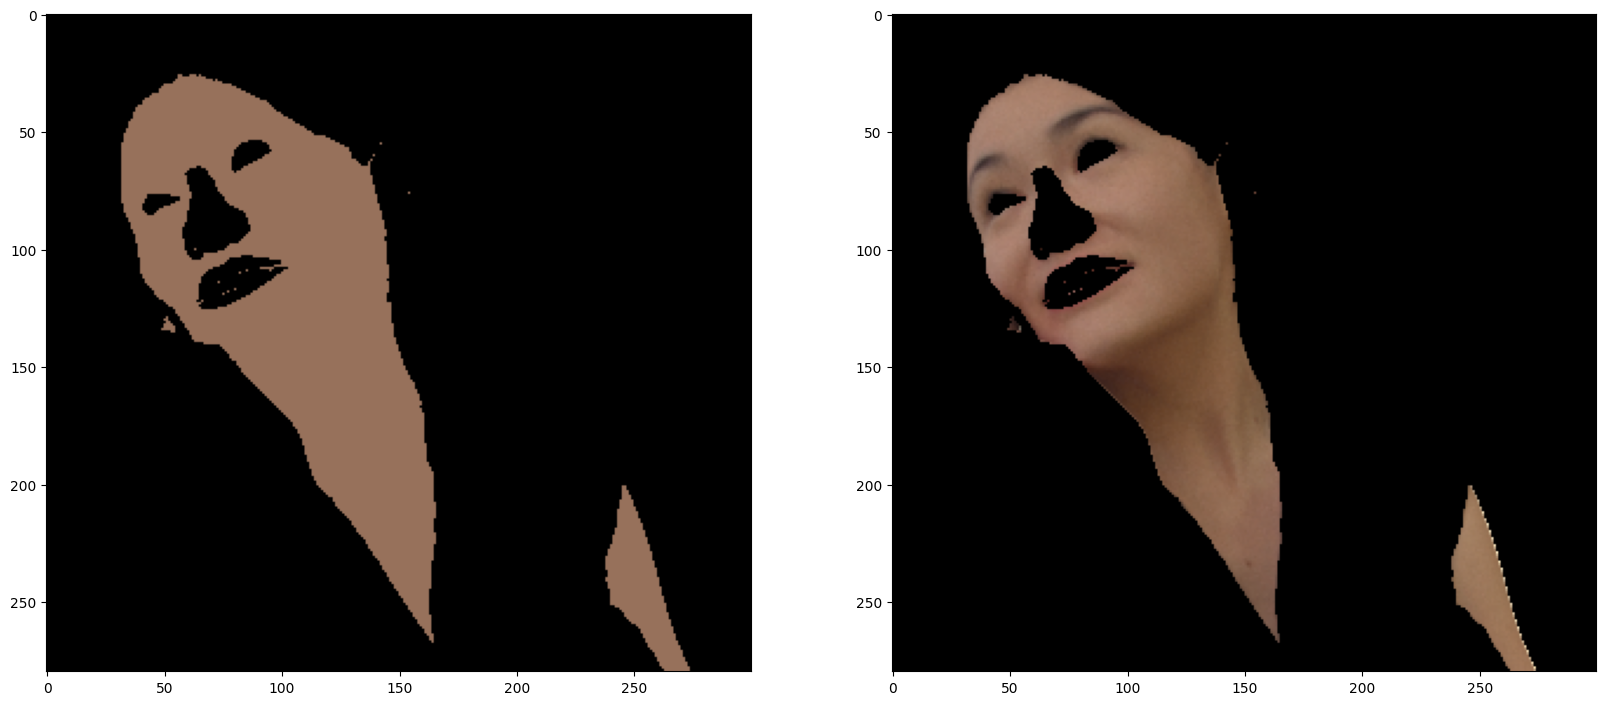

Candidate: (115,80,58), Weighted Reconstruction Error: 57.7937335320851


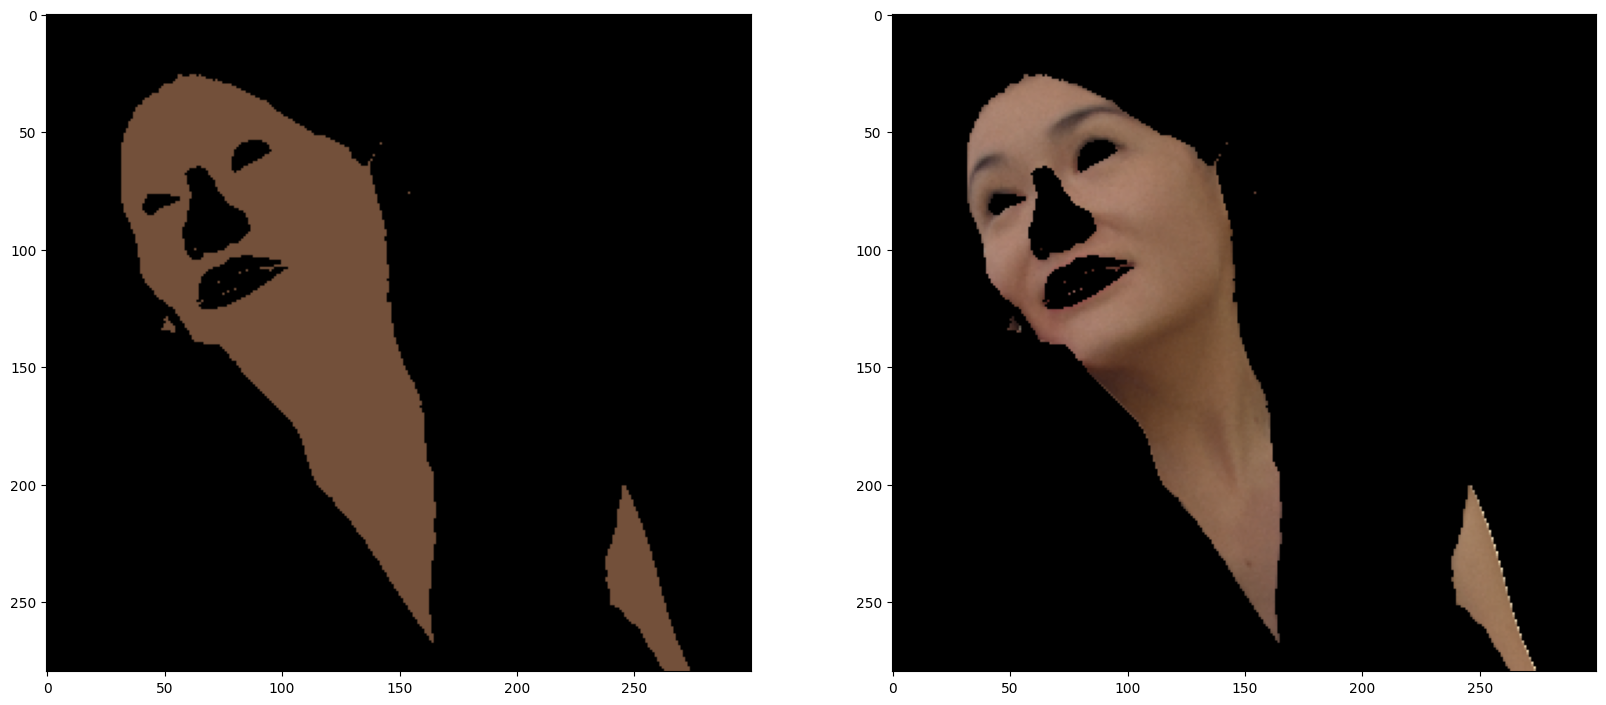

Candidate: (33,25,23), Weighted Reconstruction Error: 188.77955215705245


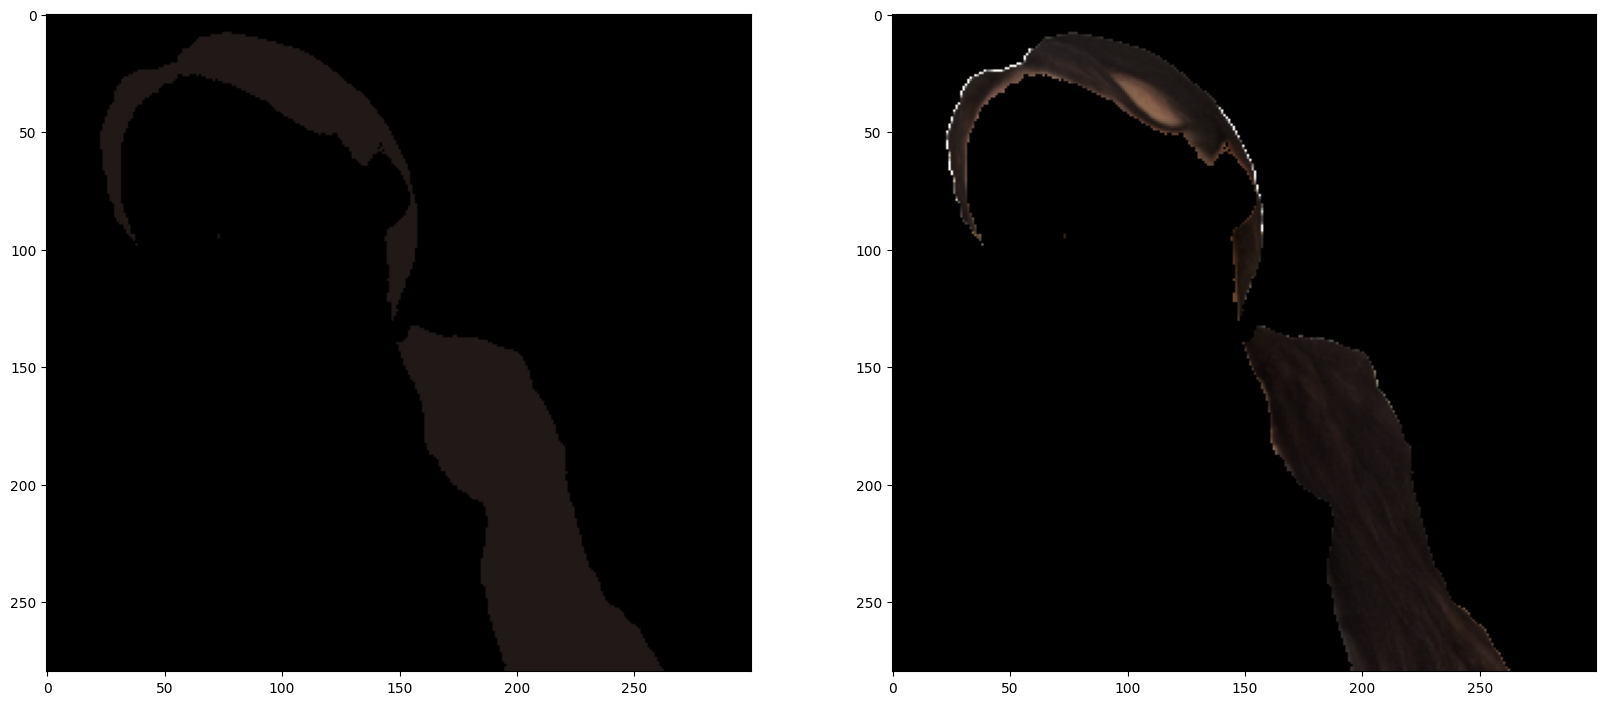

Candidate: (132,110,97), Weighted Reconstruction Error: 73.62806809255463


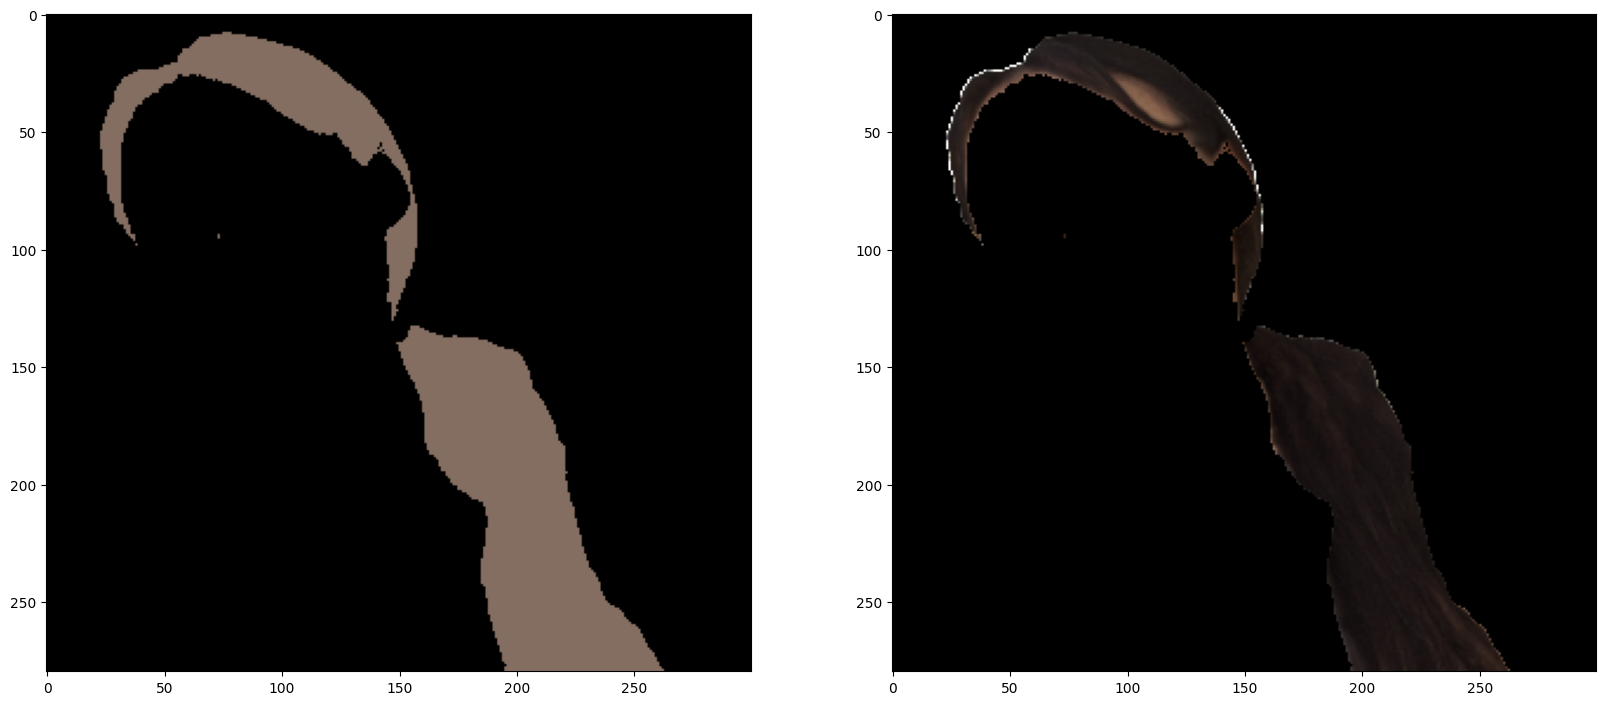

Candidate: (147,88,82), Weighted Reconstruction Error: 161.03269615490166


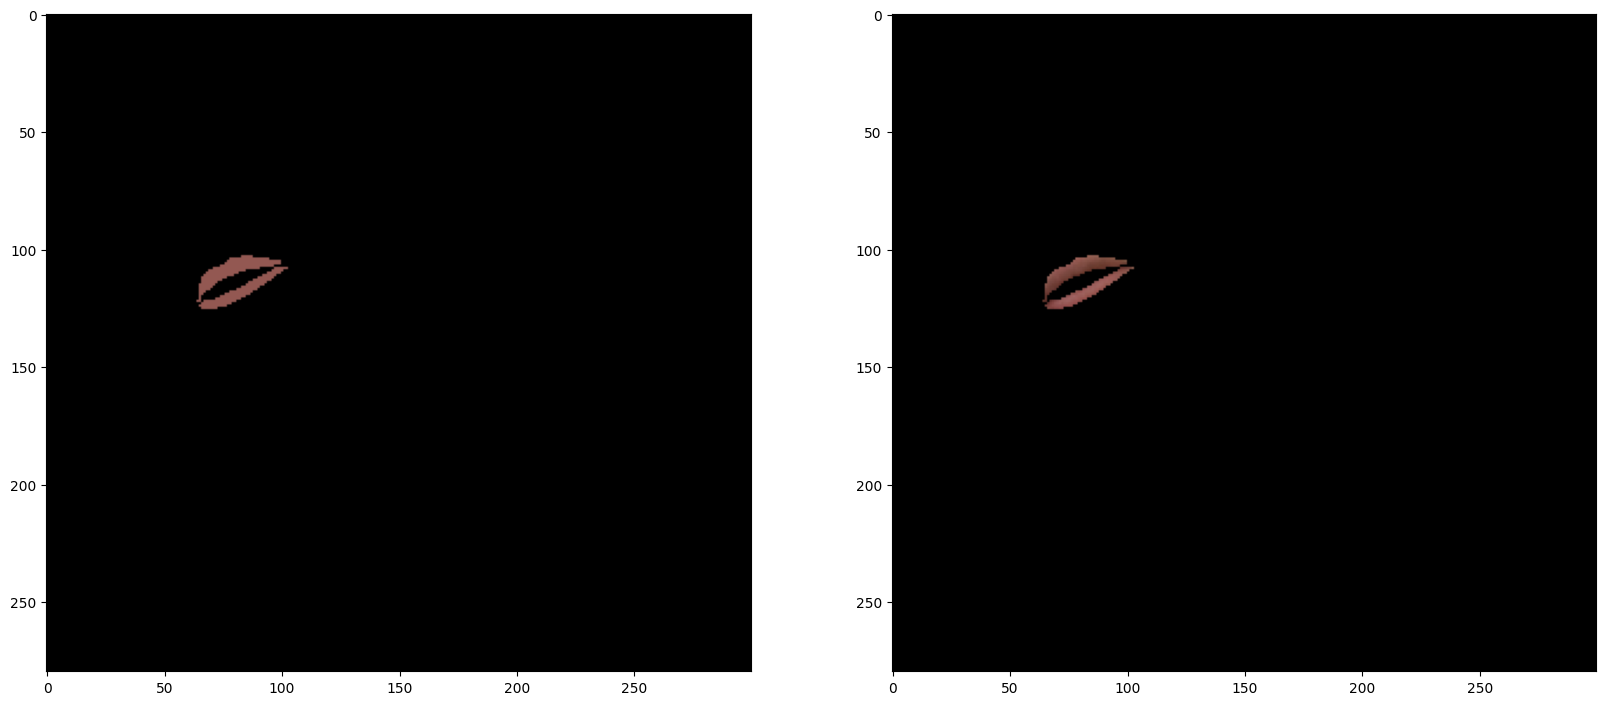

Candidate: (114,64,55), Weighted Reconstruction Error: 223.4148283191861


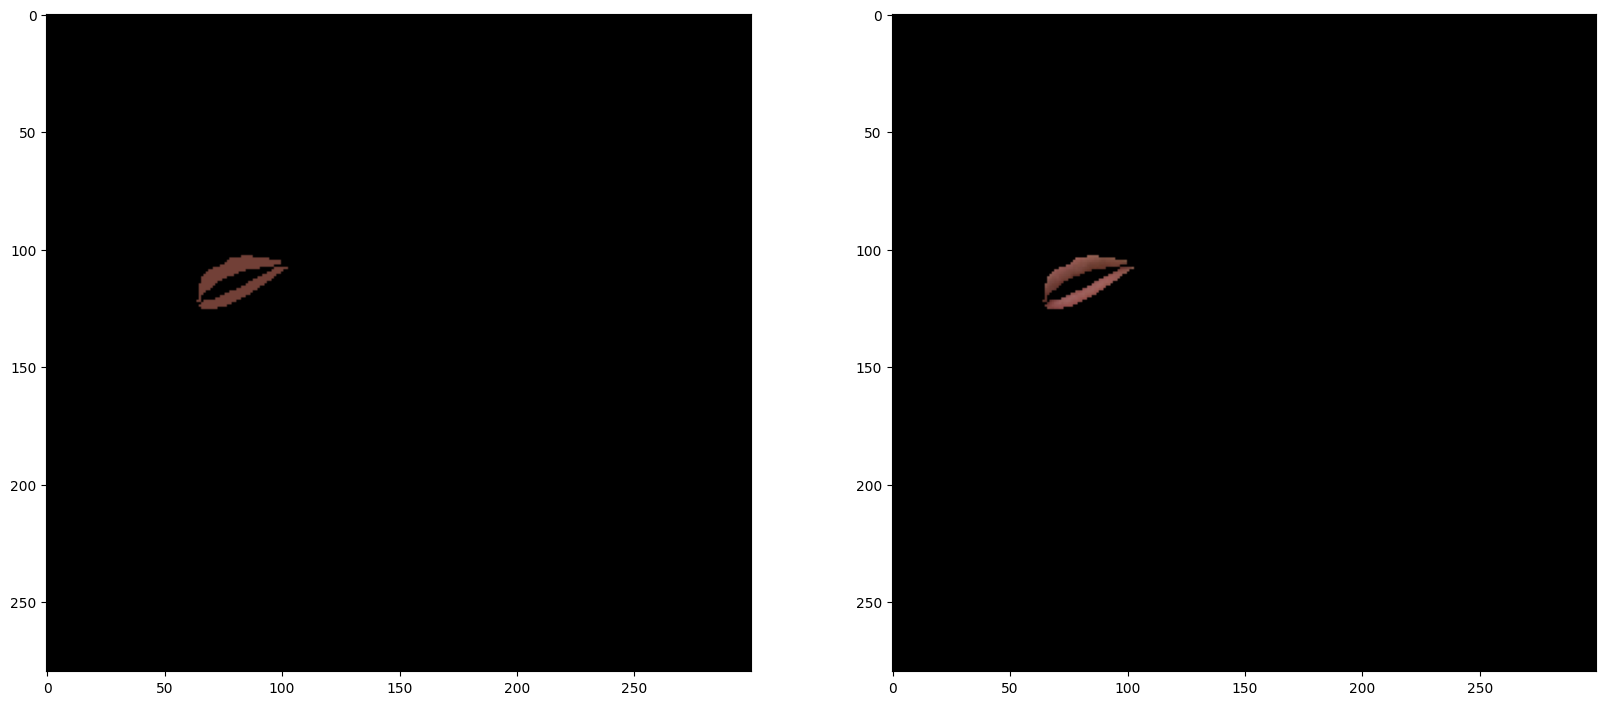

Candidate: (137,115,102), Weighted Reconstruction Error: 0.0013098509519655363


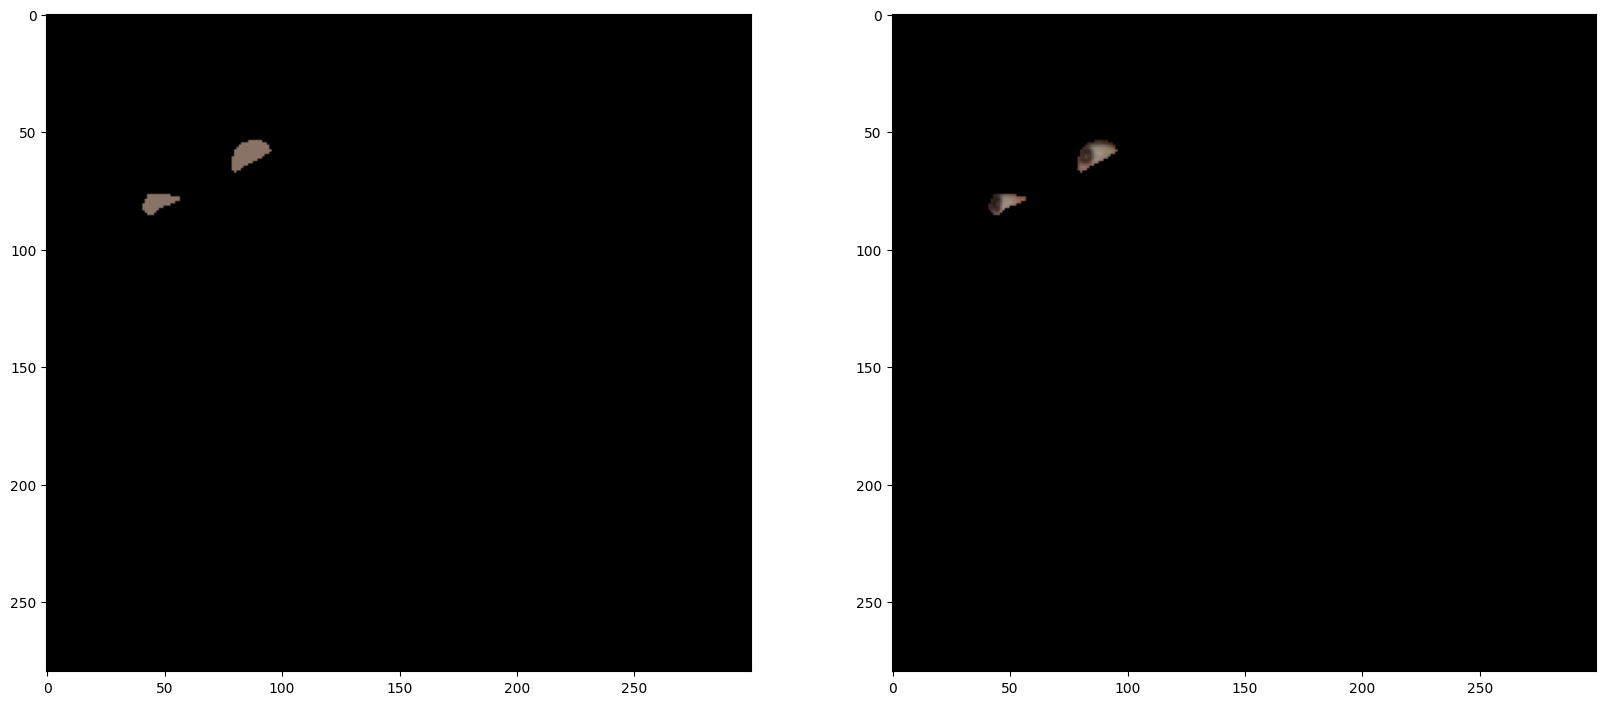

Candidate: (67,50,44), Weighted Reconstruction Error: 0.0006648600549289212


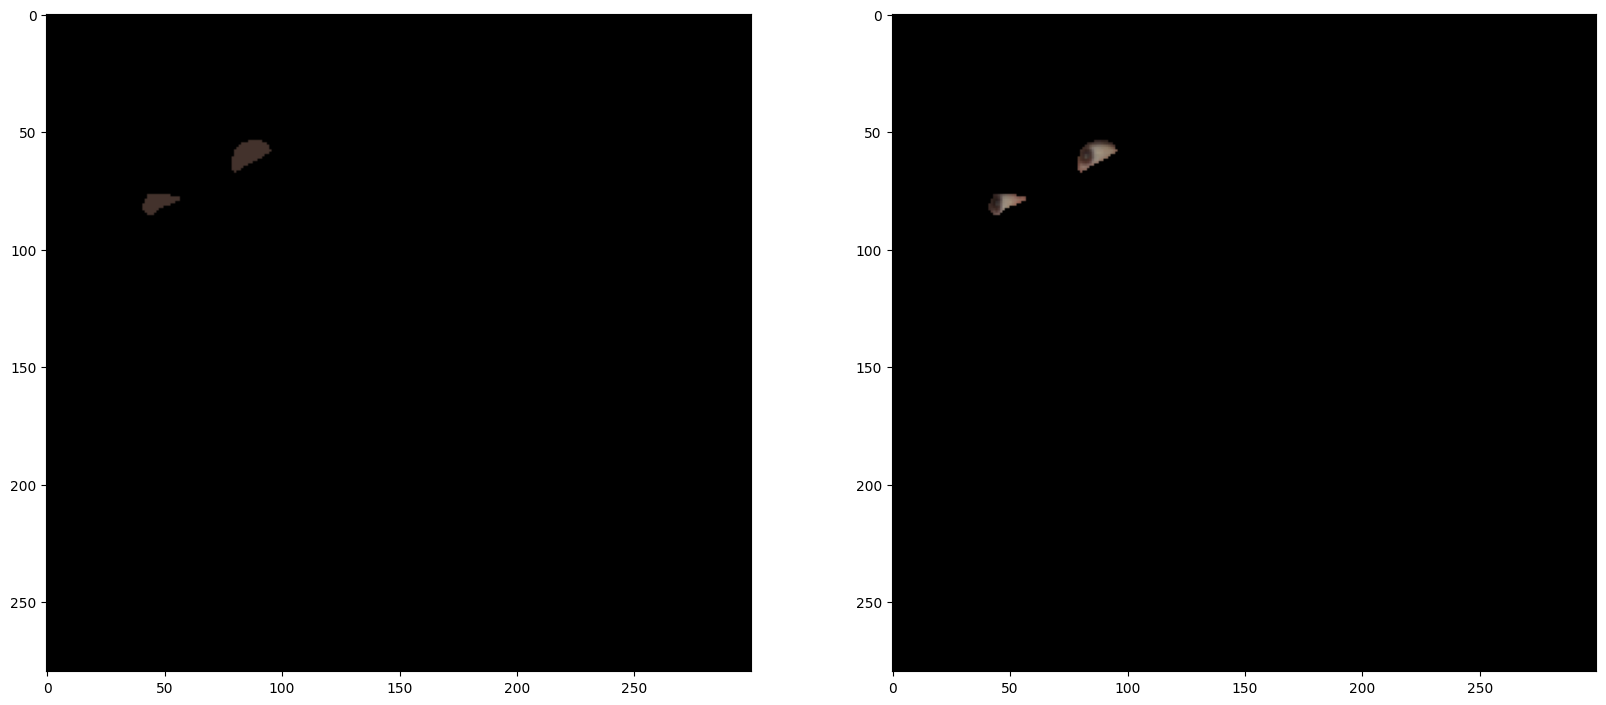

dominants


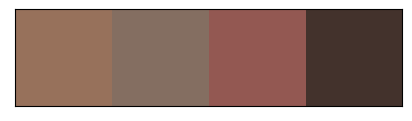

In [8]:
# extracting dominant colors from segmentation masks and computing dominants palette
dominants = color_processing.compute_user_embedding(
    img_masked, n_candidates=(3, 3, 3, 3), distance_fn=metrics.rmse, debug=True)
dominants_palette = palette.PaletteRGB('dominants', dominants)
print(dominants_palette.description())
dominants_palette.plot()

In [9]:
# computing color harmony metrics and metrics_vector (see class palette.PaletteRGB)
thresholds = (0.200, 0.422, 0.390)
subtone = palette.compute_subtone(dominants[lips_idx])
intensity = palette.compute_intensity(dominants[skin_idx])
value = palette.compute_value(dominants[skin_idx], dominants[hair_idx], dominants[eyes_idx])
contrast = palette.compute_contrast(dominants[hair_idx], dominants[eyes_idx])
dominants_palette.compute_metrics_vector(subtone, intensity, value, contrast, thresholds)
print(f'metrics_vector: {dominants_palette.metrics_vector()}')

metrics_vector: tensor([0, 0, 1, 1], dtype=torch.uint8)


In [10]:
# Picking and assigning season which minimizes Hamming distance between metrics vectors, choosing 
# among seasons with same subtone
season_palette = palette.classify_user_palette(dominants_palette, reference_palettes)
print(f'Season: {season_palette.description()}')
print(f'Subtone: {subtone} \nIntensity: {intensity} \nValue: {value} \nContrast: {contrast}')

Season: summer
Subtone: cold 
Intensity: 0.397350937128067 
Value: 0.457516352335612 
Contrast: 0.2549019753932953
